Import core numerical and utility functionality

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm.notebook import tqdm
from scipy.integrate import odeint
from scipy.optimize import fsolve

Setup

In [2]:
np.random.seed(42)

NAME = 'assignment2'
DATA_PATH = f'data/{NAME}'
MEDIA_PATH = f'media/{NAME}'
[os.makedirs(path, exist_ok=True) for path in [DATA_PATH, MEDIA_PATH]]
print('Setup complete')

Setup complete


## Part 1: Perfect Adaptation

### a) Rate-equation of $R$

Steady-state solution with rate constants plugged in:

$$
\begin{align*}
    \frac{dX}{dt} &=  S - X = 0 \implies X = S \\
    \frac{dR}{dt} &= 2 S - 2 X R = 2 S (1 - R) \\
\end{align*}
$$

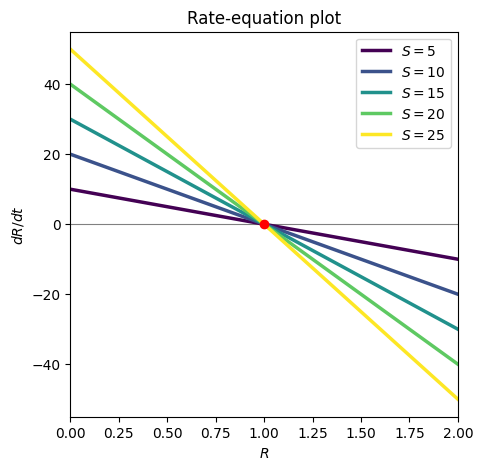

In [3]:
Ss = [5, 10, 15, 20, 25]
Rs = np.linspace(0, 2, 1000)

fig, ax = plt.subplots(1,1, figsize=(5,5))
cmap = plt.get_cmap(name="viridis", lut=len(Ss))

ax.hlines(0, 0, 2, lw=0.8, color="gray")
for (i, S) in enumerate(Ss):
    dRdt = 2 * S * (1 - Rs)
    ax.plot(Rs, dRdt, color=cmap(i), label=r"$S=$" + f"{S}", lw=2.5)

ax.scatter(1,0,color="red",zorder=10)
ax.set_xlabel(r"$R$")
ax.set_ylabel(r"$dR/dt$")
ax.set_xlim((0,2))
ax.set_title("Rate-equation plot")
ax.legend()

plt.show()

### b) Signal-response curve

It can be seen from the rate-equation plot of $R$, but also it can be derived analytically that:

$$ S \neq 0 \implies \left( \frac{dR}{dt} = 0 \iff R = 1 \right) $$

The equilibrium point $R^{*}$ is always equal to $1$ and is independent of $S$. The signal-response curve will be a horizontal line.

As can also be seen in the rate-equation plot, $\frac{dR}{dt} \gt 0$ leftwards from the equilibrium and $\frac{dR}{dt} \lt 0$ rightwards from the equilibrium. Thus, the equilbrium point $R^{*} = 1$ is stable.

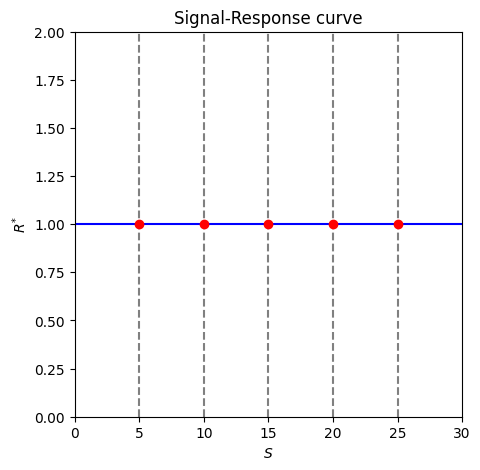

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(5,5))

ax.hlines(1, 0, 30, color="blue")
ax.scatter(Ss, np.ones(len(Ss)), color="red",zorder=10)

for (i, S) in enumerate(Ss):
    ax.vlines(S, 0, 2, linestyles="dashed", color="gray")

ax.set_xlabel(r"$S$")
ax.set_ylabel(r"$R^{*}$")

ax.set_xlim((0,30))
ax.set_ylim(0,2)
ax.set_title("Signal-Response curve")

plt.show()

### c) Time-dependent plots

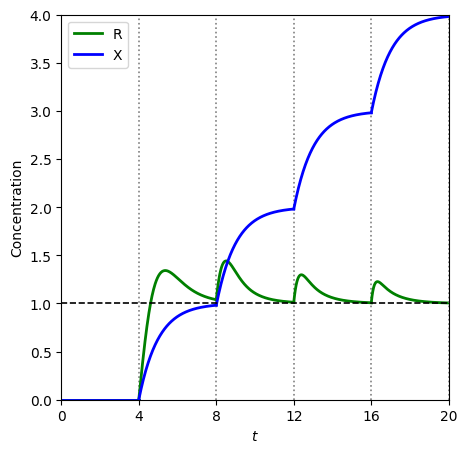

In [5]:
def perfect_adaptation(y0, t, S):
    R, X = y0
    dRdt = 2*S - 2*X*R
    dXdt = S - X
    dydt = [dRdt, dXdt]

    return dydt

Ss = np.array([0,1,2,3,4])
fig, ax = plt.subplots(1,1,figsize=(5,5))

R0 = 0
X0 = 0
y0 = [R0, X0]

for (i, S) in enumerate(Ss):
    t = np.linspace(i*4, (i+1)*4, 200)
    sol = odeint(perfect_adaptation, y0, t, args=(S,))

    R, X = sol[:, 0], sol[:, 1]
    ax.plot(t, R, color="green", lw=2.0)
    ax.plot(t, X, color="blue", lw=2.0)

    ax.vlines((i+1)*4, 0, 4, linestyles="dotted", lw=1.2, color="gray")

    y0 = [R[-1], X[-1]]

ax.hlines(1, 0, 20, linestyles="dashed", lw=1.2, color="black")

ax.set_xlim(0,20)
ax.set_ylim(0,4)
ax.set_xticks([0,4,8,12,16,20])
ax.set_xlabel(r"$t$")
ax.set_ylabel("Concentration")
ax.legend(["R", "X"])

plt.show()


The concentration of $R$ remains stable at the zero-level when $S=0$. This result could not be seen in the signal-response curve, as it was assumed that $S \neq 0$. Nonetheless, $S = 0$ is another solution for $\frac{dR}{dt} = 0$, which results in concentration of $R$ remaining at the same level for this time period.

For all remaining periods, where $S \in \{1,2,3,4\}$, the concentration of $R$ rises at first, but then starts to down-regulate and approaching $R^{*} = 1$. This corresponds with signal-response curve. Stable point $R^{*} = 1$ is independent of $S$.

The concentration of $X$ also corresponds with the previous derivation from $a)$, where, to achieve a steady-state solution, it was shown that $S = X$. At the beginning of each period, $X$ up-regulates. The increase is rapid at first, but then slows down and the concentration level approaches $X^{*}$ equal to the corresponding $S$.

## Part 2: Feedback loops

### a) Rate-equations

In [6]:
def G(u,v,J,K):
    """The Goldbeter-Koshland function."""
    return (2*u*K) / (v - u + v*J + u*K + np.sqrt((v-u+v*J+u*K)**2 - 4*(v-u)*u*K))

In [7]:
def homeostasis(R, S, k0, k2, k3, k4, j3, j4):
    ER = G(k3, k4*R, j3, j4)
    dRdt = k0 * ER - k2 * S * R
    return dRdt

def mutual_inhibition(R, S, k0, k1, k2, k2_prime, k3, k4, j3, j4):
    ER = G(k3, k4*R, j3, j4)
    dRdt = k0 + k1*S - k2*R - k2_prime*ER*R
    return dRdt

def mutual_activation(R, S, k0, k1, k2, k3, k4, j3, j4):
    ER = G(k3*R, k4, j3, j4)
    dRdt = k0*ER + k1*S - k2*R
    return dRdt

In [34]:
def plot_rate_equation(ax, Rs, Ss, model, *args):
    cmap = plt.get_cmap(name="viridis", lut=len(Ss))
    ax.hlines(0, 0, np.max(Rs), lw=0.8, color="gray")

    for (i, S) in enumerate(Ss):
        dRdt = model(Rs, S, *args)
        ax.plot(Rs, dRdt, color=cmap(i), label=r"$S=$" + f"{S}", lw=2.5)

    ax.set_xlabel(r"$R$")
    ax.set_ylabel(r"$dR/dt$")
    ax.set_xlim((0,np.max(Rs)))
    ax.set_xticks(np.linspace(0, np.max(Rs), 5))
    ax.legend()

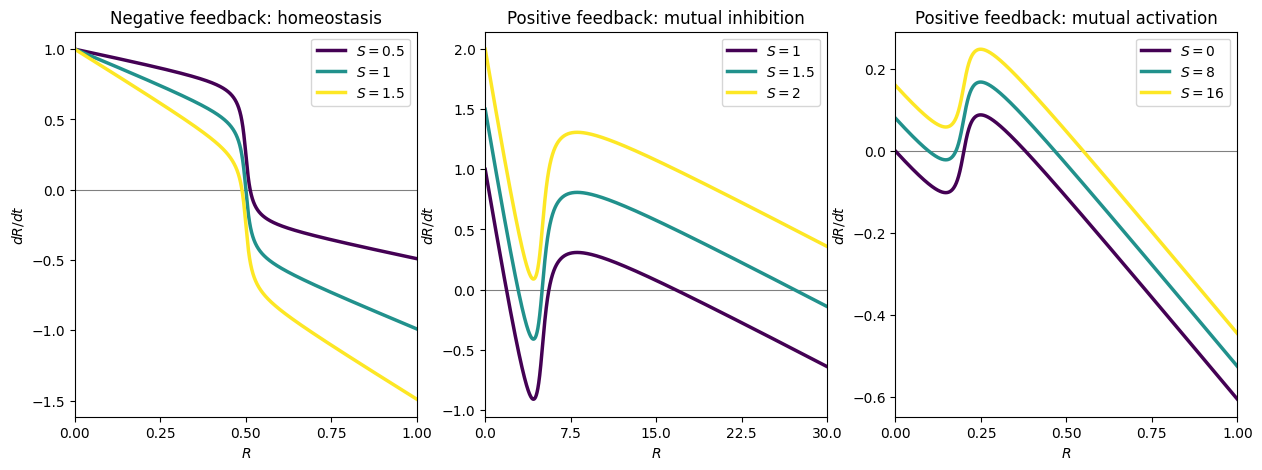

In [35]:
fig, ax = plt.subplots(1,3,figsize=(15,5))

ax[0].set_title("Negative feedback: homeostasis")
ax[1].set_title("Positive feedback: mutual inhibition")
ax[2].set_title("Positive feedback: mutual activation")

# --- Negative feedback: homeostasis ---
k0 = 1
k2 = 1
k3 = 0.5
k4 = 1
j3 = 0.01
j4 = 0.01

homeostasis_params = [k0, k2, k3, k4, j3, j4]

Ss = [0.5, 1, 1.5]
Rs = np.linspace(0, 1, 10000)
plot_rate_equation(ax[0], Rs, Ss, homeostasis, *homeostasis_params)

# --- Positive feedback: mutual inhibition ---
k0 = 0
k1 = 1
k2 = 0.05
k2_prime = 0.5
k3 = 1
k4 = 0.2
j3 = 0.05
j4 = 0.05

mutual_inhibition_params = [k0, k1, k2, k2_prime, k3, k4, j3, j4]

Ss = [1,1.5,2]
Rs = np.linspace(0, 30, 10000)
plot_rate_equation(ax[1], Rs, Ss, mutual_inhibition, *mutual_inhibition_params)

# --- Positive feedback: mutual activation ---
k0 = 0.4
k1 = 0.01
k2 = 1
k3 = 1
k4 = 0.2
j3 = 0.05
j4 = 0.05

mutual_activation_params = [k0, k1, k2, k3, k4, j3, j4]

Ss = [0,8,16]
Rs = np.linspace(0, 1, 10000)
plot_rate_equation(ax[2], Rs, Ss, mutual_activation, *mutual_activation_params)

plt.show()

### b) Signal-response curves (Bifurcation plots)

The approximate roots of rates $\frac{dR}{dt}$ could be read from the plot, but to create a bifurcation diagram, more evaluations for different $S$ are needed. The analytical solution for the root of $\frac{dR}{dt}$ is very much non-trivial due to the complexity of the Goldbeter-Koshland function. To find all roots, we will A̷̗̙̠̠̖͉̣̜̟̳͊H̶͙̟̻̠͇̆́͌̈́͝Ḣ̴̘͘H̸̛̙̼̟̥͕̘̘͍̅͋͐̄̄̒̃̅͐̉͜͜͝Ḧ̶̩̠́̇͒͊͒͂̀̽̾͘ͅH̴̛̼͕̲̀͐̀͗͗̊́͒̐̆̚͘̕͝H̷̡̤̦̻̼̜̠̖͒̿́͒̔͐͛̾͒̋͌̎͂͘H̴̨̛̺̰̺͗́̅͆̊ͅḦ̶̡̰̪̭̠̞̘̜͙̝͉̼̆̄̎͘Ḩ̸̻͍͒̐̇̊̋̆͗̿͛̕͝Ḫ̵̨̺͕̟̹̹͎̰̬̩͍͉̂̀̂̽͛̍̂̀̇͗͛̄̈͆̄H̵̨̡̱̆H̶̘͖̭̱̳̜̯͔̭̿̇̄͛̾̾̄̒̉̕͜͝Ḩ̴̢͎̮͔̬̰̈ͅH̶̤̤̘̤̞̯̃͐̔͑̀͜Ḧ̸̜̪́͑̊̃̐̃̄̒̒̋͗̚͝͝H̶͙̤̻͉̺̩̝̼̪̳̭̻͐̈́ͅH̴̥̼̞̹̼̱̘̭̀͝͝H̷̖̱͍͙̝̮̟̤̫̱̦͕̝̐́̇̐̃̏͠ͅH̴̡̛̙̖̰̃̓̏̓̊̇̈́͘͘H̷̢̨͇̝̯̣̝͇͉̬̯͖̺̾̆͛̾̿́̓̌͋͌̾̌͒̇ͅḦ̵̨̨̨̹̱͖̳͈͈͍̳̦͔̫́̓̈́͆͊͒͠H̸̻̳̊̾͘ͅ

nvm I fixed it (too me 4 hours) haha :D

To find all roots, we will utilize the `scipy.optimize.fsolve` method, which finds the root(s) of the function, given the initial estimate(s). To create a bifurcation plot we need to find all function roots $R^{*}$ for a given signal strength $S$. Finding all function roots is a difficult numerical task, but we can do that for these three specific scenarios by only looking through the subset of the domain, based on the plots from a).

Given the interval $[ x_{\text{start}}, x_{\text{stop}} ]$ and the step size $\Delta x$ the `fsolve` was evaluated for all initial estimates $x \in \{ x_{\text{start}}, x_{\text{start}} + \Delta x, \dots, x_{\text{stop}} \}$. If `fsolve` returned a root that wasn't found before (for the comparison, `np.isclose` was used), the root was added to the list. This step was repeated for all signal strengths $s \in S$ supplied as a function parameter.

The algorithm for finding roots of function $f(R, S, \dots)$, where $\dots$ represents function-dependent additional parameters such as $k_0, k_1, k_2, \dots$ presents as follows:

Given:
   * $f$ function for which we want to find the roots
   * $s$ signal strength
   * $x_{\text{start}}$ starting point of scanning domain subset
   * $x_{\text{stop}}$ end point of for scanning domain subset 
   * $\Delta x$ step size for scanning domain subset
1. Initialize empty array $R$ where the roots will be stored
2. For all $x \in \{ x_{\text{start}}, x_{\text{start}} + \Delta x, \dots, x_{\text{stop}} \}$:
   1. Find $r$ root of $f$ using `fsolve` and starting estimate $x$
   2. If $r \notin R$, add $r$ to $R$

In [65]:
def find_roots(func, xmin, xmax, dx):
    roots = np.array([])
    xs = np.arange(start=xmin, stop=xmax, step=dx)
    for x in xs:
        r = fsolve(func, [x])
        if np.isclose(func(r), 0) and not np.count_nonzero(np.isclose(roots, r)):
            roots = np.append(roots, r)
    return roots

In [40]:
def root_function_homeostasis(S):
    return lambda R : homeostasis(R, S, *homeostasis_params)

def root_function_mutual_inhibition(S):
    return lambda R : mutual_inhibition(R, S, *mutual_inhibition_params)

def root_function_mutual_activation(S):
    return lambda R : mutual_activation(R, S, *mutual_activation_params)

In [98]:
def bifurcation_plot(ax, func_generator, Ss, xmin, xmax, dx):
    ax.grid()
    for S in Ss:
        function = func_generator(S)
        roots = find_roots(function, xmin, xmax, dx)
        ax.scatter(np.repeat(S, roots.shape[0]), roots, color="blue", s=3.5)
        ax.set_xlabel(r"$S$")
        ax.set_ylabel(r"$R^{*}$")

C:\Users\User23718901\AppData\Local\Temp\ipykernel_13940\1208384143.py:5: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  root = fsolve(func, [x])
C:\Users\User23718901\AppData\Local\Temp\ipykernel_13940\1208384143.py:5: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  root = fsolve(func, [x])


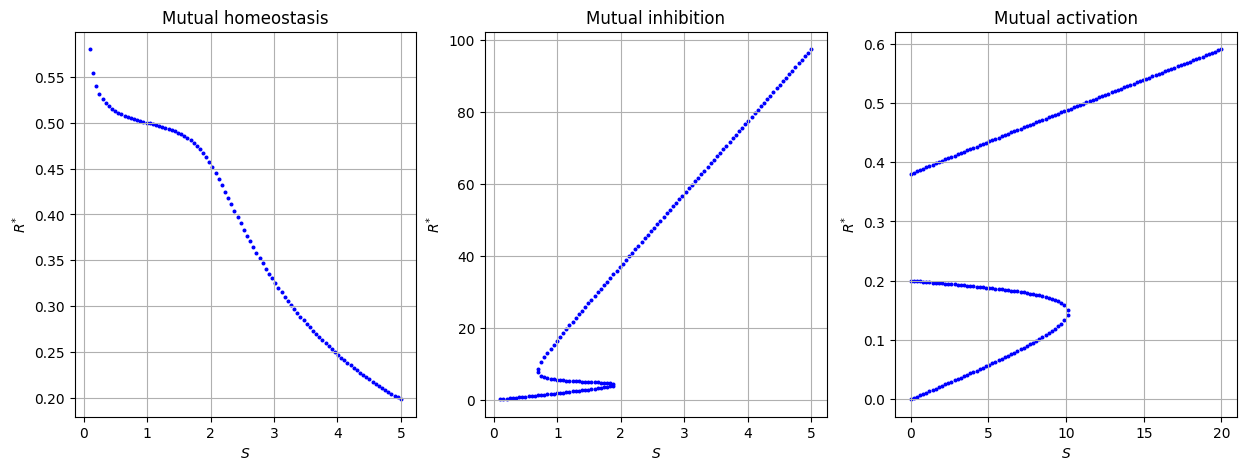

In [99]:
fig, axes = plt.subplots(1,3,figsize=(15,5))

# Homeostasis
ax = axes[0]
Ss = np.linspace(0.1, 5, 100)
xmin = 0
xmax = 10
dx = 0.1

bifurcation_plot(ax, root_function_homeostasis, Ss, xmin, xmax, dx)
ax.set_title("Mutual homeostasis")

# Mutual inhibition
ax = axes[1]
Ss = np.linspace(0.1, 5, 100)
xmin = 0
xmax = 100
dx = 1.0

bifurcation_plot(ax, root_function_mutual_inhibition, Ss, xmin, xmax, dx)
ax.set_title("Mutual inhibition")

# Mutual activation
ax = axes[2]
Ss = np.linspace(0, 20, 100)
xmin = 0
xmax = 10
dx = 0.1

bifurcation_plot(ax, root_function_mutual_activation, Ss, xmin, xmax, dx)
ax.set_title("Mutual activation")


plt.show()